In [1]:
import logging
from astrodb_utils import load_astrodb, AstroDBError
from simple.utils.spectra import check_spectrum_plottable
from astrodb_utils.fits import add_missing_keywords, add_wavelength_keywords, check_header
from astropy.io import fits
import astropy.units as u
import os
import pandas as pd
import numpy as np
from specutils import Spectrum1D

INFO     - astrodb_utils.publications - logger.parent.name: astrodb_utils, logger.parent.level: 20


In [2]:
path = "/Users/guanying/SIMPLE Archieve/SIMPLE-db/scripts/ingests/Zhang18/sty2054_supplemental_files"

In [3]:
import os
print(os.path.exists("/Users/guanying/SIMPLE Archieve/SIMPLE-db/scripts/ingests/Zhang18/sty2054_supplemental_files/SDSS_J134749.74+333601.7_sdL0_SDSS_Primeval-I.txt"))


True


Reading text file: SDSS_J134749.74+333601.7_sdL0_SDSS_Primeval-I.txt


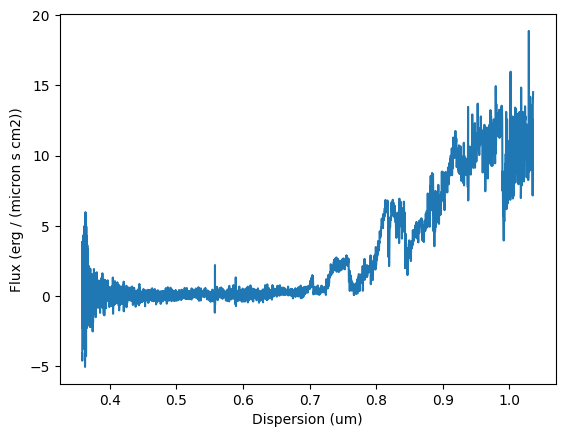

Reading text file: ULAS_J124947.04+095019.8_sdL1_FIRE_Magellan_Primeval-I.txt


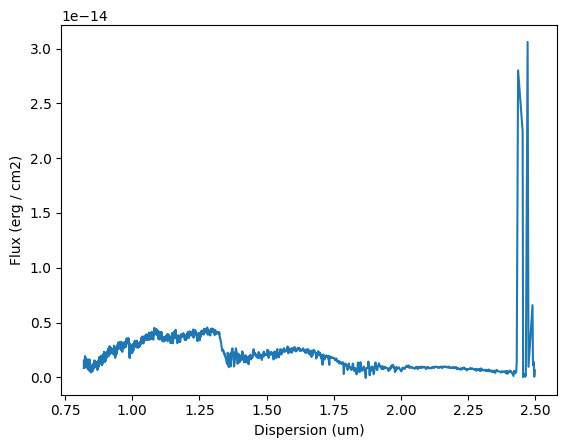

Reading text file: README.txt
Could not read README.txt: could not convert string 'Our' to float64 at row 0, column 1.
Reading text file: ULAS_J133836.97-022910.7_sdL7_FIRE_Magellan_Primeval-I.txt


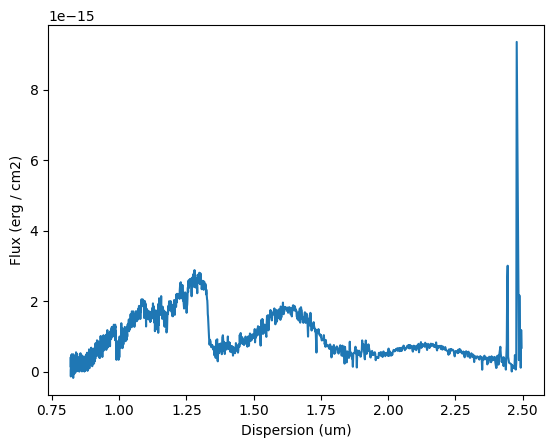

Total files plotted: 3


In [4]:
# Handle txt and fits file separately
file_plotted = 0
file_failed = 0
for filename in os.listdir(path):
    if filename.endswith(".fits"):
        continue
    
    print(f"Reading text file: {filename}")

    file_path = os.path.join(path, filename)
    
    try:
        data = np.loadtxt(file_path, comments="#", encoding="latin1")

        # column1: #w         column2:flux          
        if (filename == "SDSS_J134749.74+333601.7_sdL0_SDSS_Primeval-I.txt"):
            wavelength = (data[:, 0] * u.AA).to(u.um)
            flux = data[:, 1] * (u.erg / (u.cm**2 * u.s * u.micron))

        # column1: #w (micron)         column2:flux          
        else:
            wavelength = (data[:, 0] * u.um)
            flux = data[:, 1] * (u.erg / (u.cm**2))
        # check plottability
        spectrum = Spectrum1D(spectral_axis=wavelength, flux=flux)
        check_spectrum_plottable(spectrum, show_plot=True)
        file_plotted += 1
    
    except Exception as e:
        print(f"Could not read {filename}: {e}")
        file_failed += 1
print(f"Total files plotted: {file_plotted}")


In [5]:
# calculate wavelength based on the header info
# wavelength = CRVAL1 + (i + 1 − CRPIX1) × CDELT1, 
#corrected the flux arrays matching with wavelength axis
def calculate_wavelength_micron(header, length):
    cdelt = header.get('CDELT1', header.get('CD1_1'))
    crval = header['CRVAL1']
    crpix = header['CRPIX1']

    # determine the current unit
    if crval >= 5000:
        unit = u.AA
    elif 100 <= crval < 10000:
        unit = u.nm
    else:
        unit = u.micron

    index = np.arange(length)
    wavelength = crval + (index - (crpix - 1)) * cdelt

    # convert to microns
    wavelength_micron = (wavelength * unit).to(u.micron)

    return wavelength_micron


In [6]:
def calculate_wavelength(header):
    cdelt = header.get('CDELT1', header.get('CD1_1'))
    crval = header['CRVAL1']
    crpix = header['CRPIX1']
    naxis = header['NAXIS1']
    index = np.arange(naxis)

    wavelength = (crval + (index + 1 - crpix) * cdelt) * u.Angstrom
    return wavelength.to(u.um)

In [7]:
# Process file with Instrument XShooter
def process_instrument_a(file_path, header, flux_data):
    flux = flux_data * u.Unit("erg / (cm2 s angstrom)")
    wavelength = calculate_wavelength(header)
    add_wavelength_keywords(header=header, wavelength_data=wavelength)
    
    spectrum = Spectrum1D(spectral_axis=wavelength, flux=flux)
    if check_spectrum_plottable(spectrum, raise_error=True, show_plot=True):
        print(f"Plotable file name (A): {os.path.basename(file_path)}")
        return True
    return False

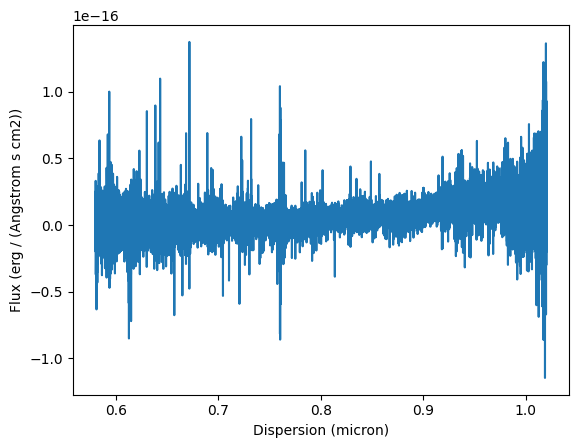

Plotable file name: ULAS_J021642.96+004005.7_sdL4_Xshooter_VIS_Primeval-I.fits


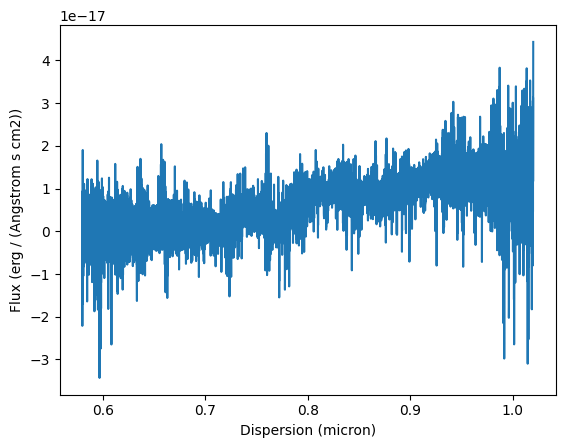

Plotable file name: ULAS_J223302.03+062030.8_esdL0.5_Xshooter_VIS_Primeval-IV.fits


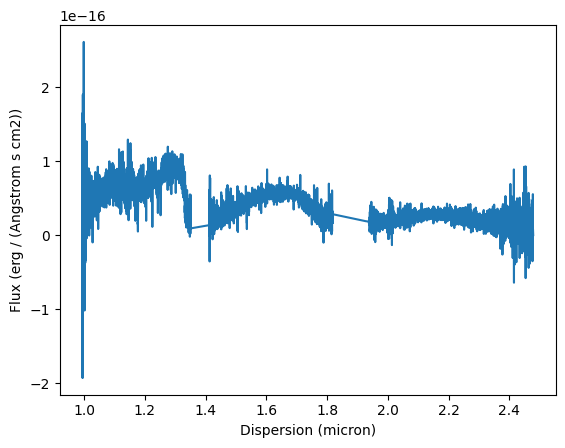

Plotable file name: ULAS_J141203.85+121609.9_sdL5_Xshooter_NIR_Primeval-IV.fits


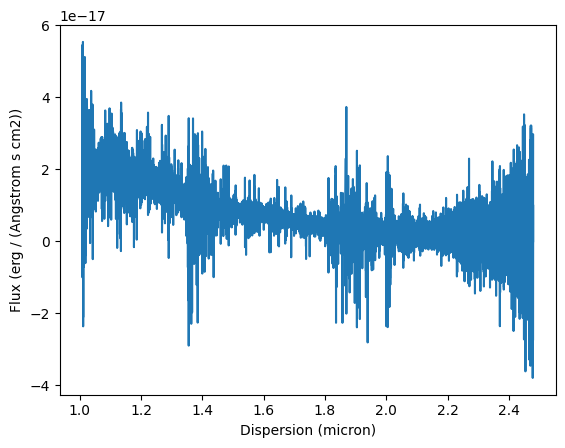

Plotable file name: SDSS_J010448.46+153501.8_usdL1.5_Xshooter_NIR_Primeval-II.fits


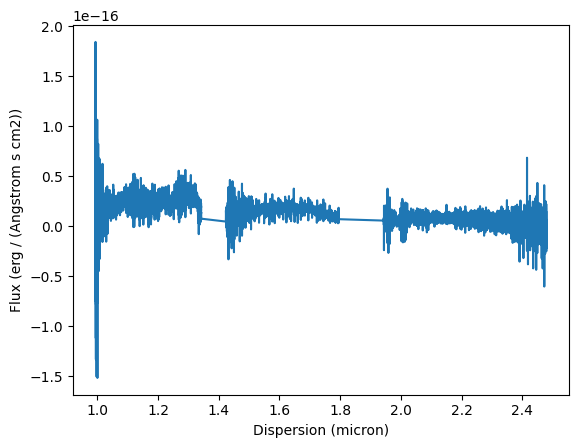

Plotable file name: ULAS_J021642.96+004005.7_sdL4_Xshooter_NIR_Primeval-I.fits


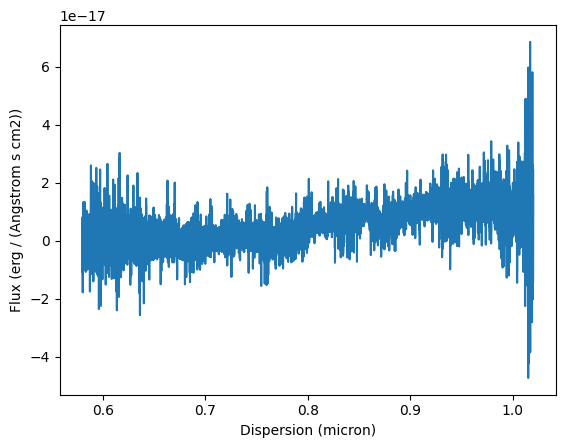

Plotable file name: ULAS_J230711.01+014447.1_usdL4.5_Xshooter_VIS_Primeval-III.fits


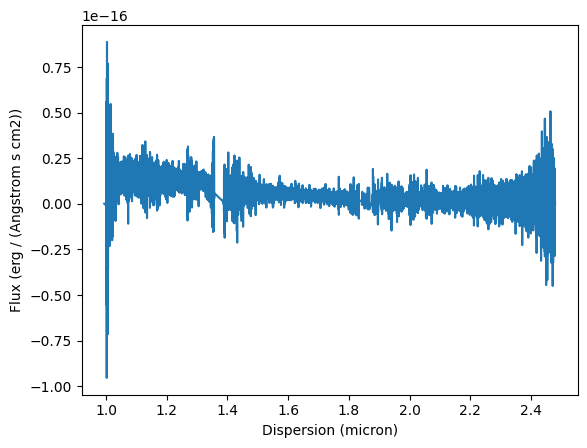

Plotable file name: ULAS_J230711.01+014447.1_usdL4.5_Xshooter_NIR_Primeval-III.fits


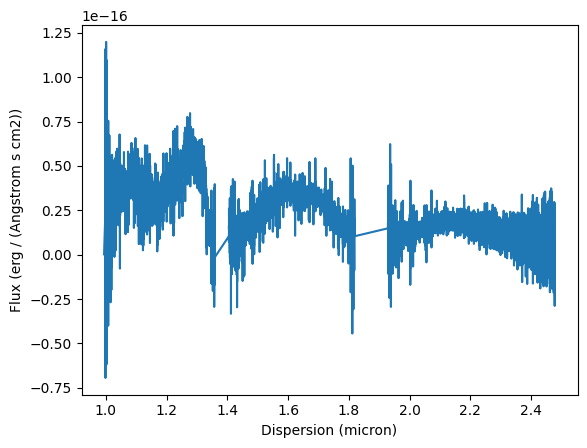

Plotable file name: ULAS_J233227.03+123452.0_L6p+T4p_Xshooter_NIR_Primeval-IV.fits


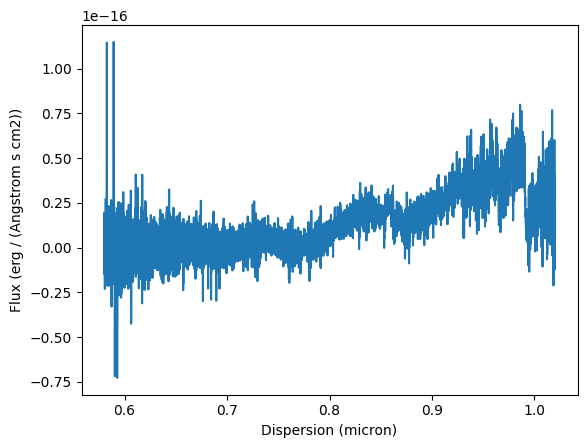

Plotable file name: 2MASS_J06164006-6407194_esdL6_Xshooter_VIS_Primeval-I.fits


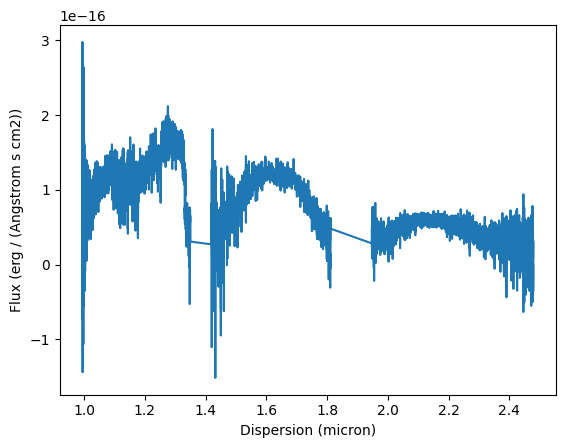

Plotable file name: 2MASS_J06453153-6646120_sdL8_Xshooter_NIR_Primeval-IV.fits


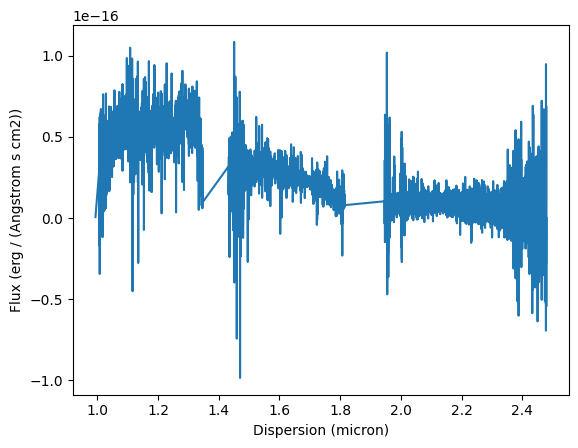

Plotable file name: 2MASS_J06164006-6407194_esdL6_Xshooter_NIR_Primeval-I.fits


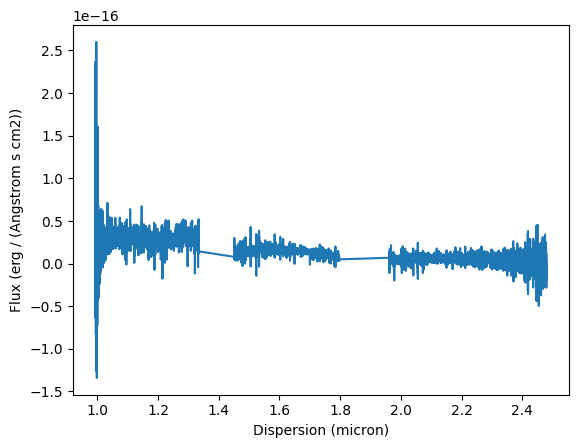

Plotable file name: ULAS_J151913.03-000030.0_sdL4_Xshooter_NIR_Primeval-I.fits


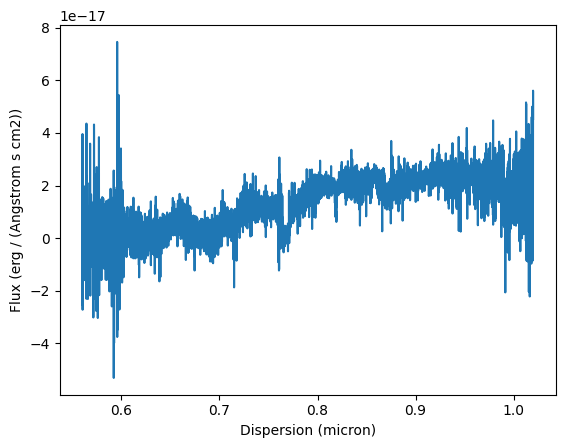

Plotable file name: SDSS_J010448.46+153501.8_usdL1.5_Xshooter_VIS_Primeval-II.fits


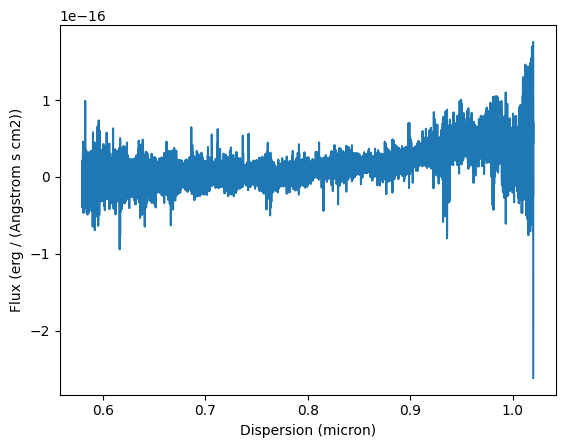

Plotable file name: ULAS_J141203.85+121609.9_sdL5_Xshooter_VIS_Primeval-IV.fits


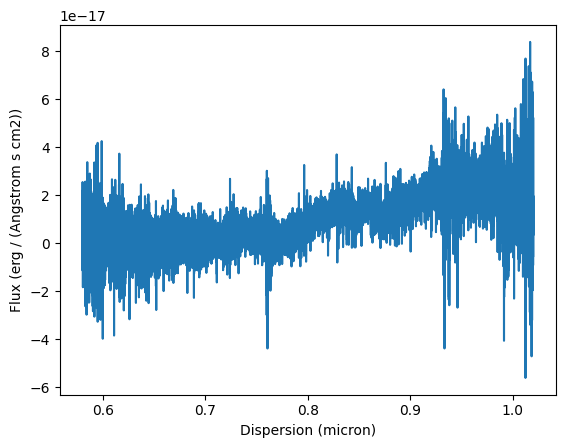

Plotable file name: ULAS_J151913.03-000030.0_sdL4_Xshooter_VIS_Primeval-I.fits


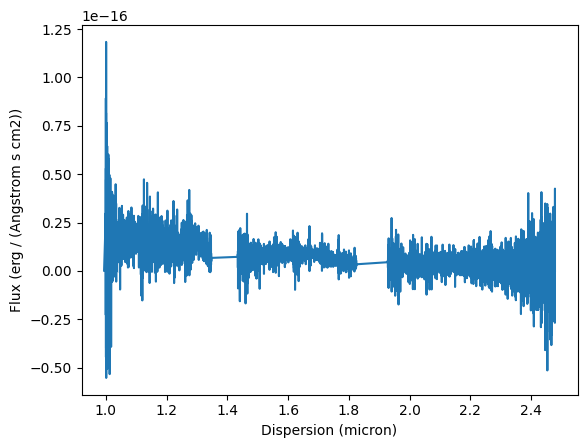

Plotable file name: ULAS_J223302.03+062030.8_esdL0.5_Xshooter_NIR_Primeval-IV.fits


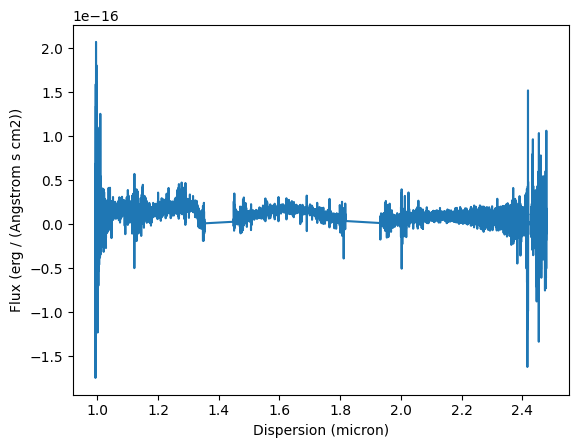

Plotable file name: ULAS_J130710.22+151103.4_sdL8_Xshooter_NIR_Primeval-IV.fits


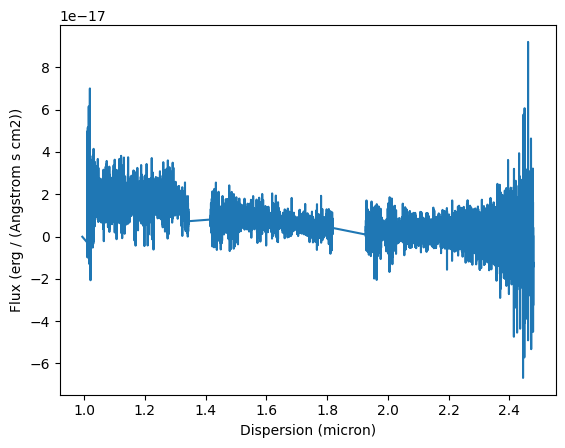

Plotable file name: ULAS_J020858.62+020657.0_esdL3_Xshooter_NIR_Primeval-III.fits


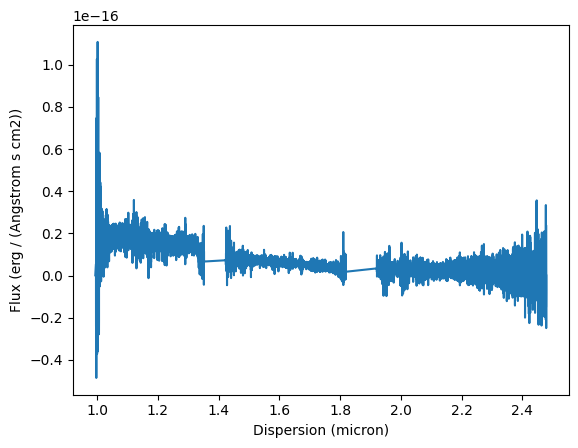

Plotable file name: ULAS_J135058.85+081506.8_usdL3_Xshooter_NIR_Primeval-III.fits


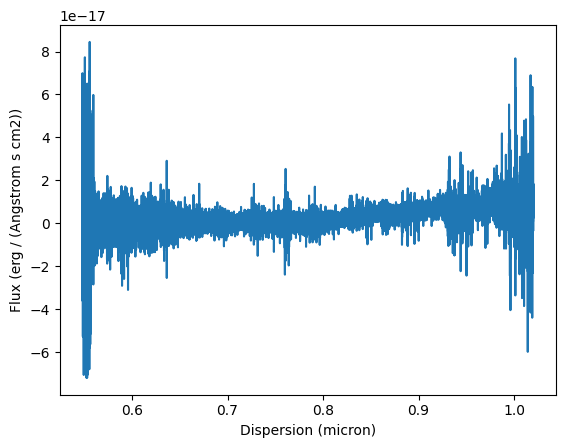

Plotable file name: ULAS_J130710.22+151103.4_sdL8_Xshooter_VIS_Primeval-IV.fits.fits


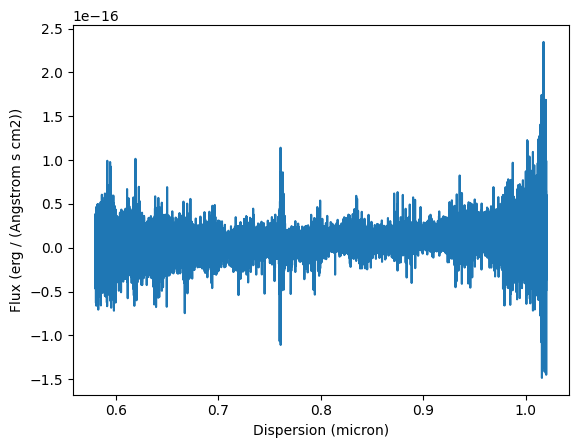

Plotable file name: ULAS_J024035.36+060629.3_sdM7_Xshooter_VIS_Primevl-IV.fits


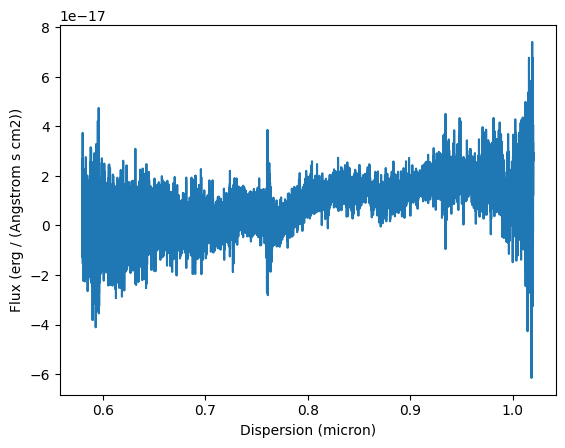

Plotable file name: ULAS_J135058.85+081506.8_usdL3_Xshooter_VIS_Primeval-III.fits


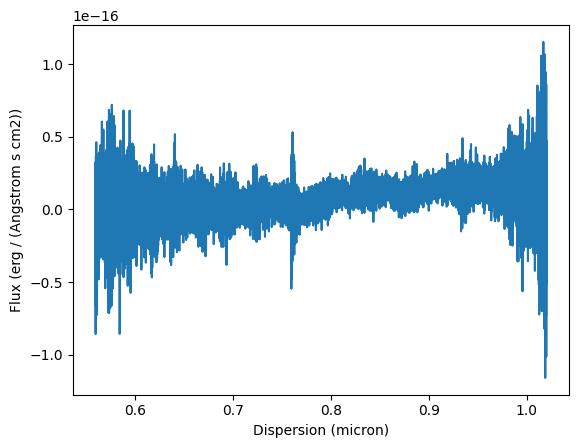

Plotable file name: ULAS_J020858.62+020657.0_esdL3_Xshooter_VIS_Primeval-III.fits


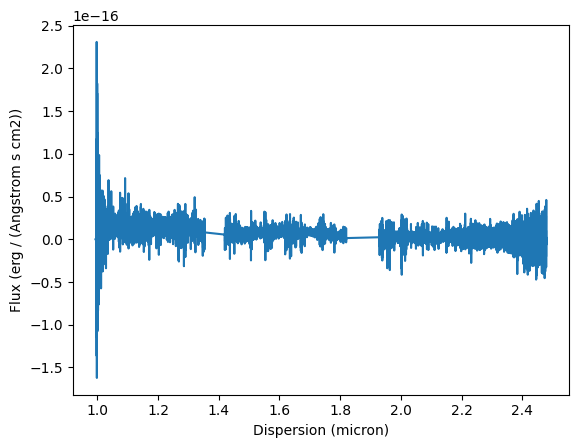

Plotable file name: ULAS_J024035.36+060629.3_sdM7_Xshooter_NIR_Primevl-IV.fits


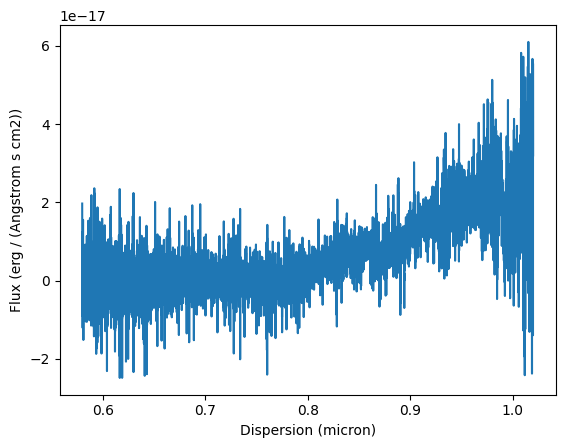

Plotable file name: ULAS_J233227.03+123452.0_L6p+T4p_Xshooter_VIS_Primeval-IV.fits


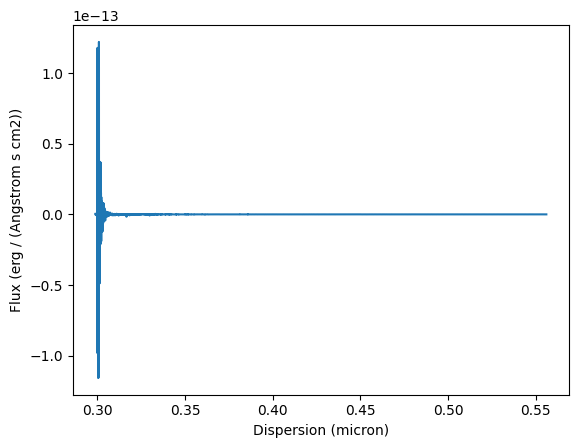

Plotable file name: SDSS_J010448.46+153501.8_usdL1.5_Xshooter_UVB_Primeval-II.fits


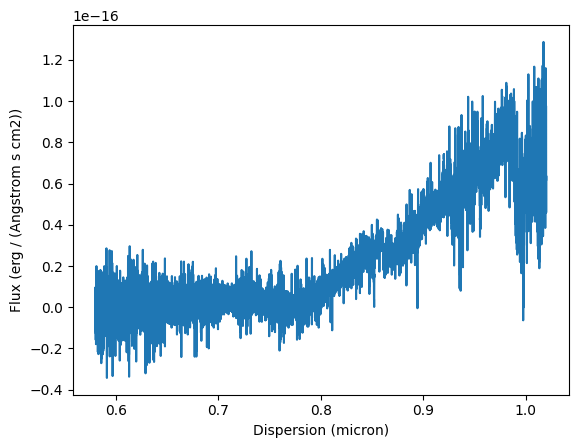

Plotable file name: 2MASS_J06453153-6646120_sdL8_Xshooter_VIS_Primeval-IV.fits

Total files plotted: 30
Total files failed: 1


In [8]:
# Testing on X-Shooter instrument:
# VIS, wavelength range 559.5-1024 nm
# NIR, wavelength range 1024-2480 nm
# UVB, wavelength range 300-559.5 nm

for filename in os.listdir(path):
    if not filename.endswith("fits"):
        continue

    file_path = os.path.join(path, filename)
    try:
        with fits.open(file_path) as hdul:
            header = hdul[0].header
            flux_data = hdul[0].data

            if flux_data.shape[0] == 4 and flux_data.shape[1] == 1:
                # handle 3D flux, take the first slice 
                flux_data = flux_data[0, 0, :]

            flux = flux_data * u.Unit("erg / (cm2 s angstrom)")

            # Calculate wavelength from actual data length
            if 'CRVAL1' in header and ('CDELT1' in header or 'CD1_1' in header) and 'CRPIX1' in header:
                wavelength = calculate_wavelength_micron(header, length=len(flux_data))

            else:
                fix_header = add_missing_keywords(header)
                raise ValueError(f"Header of {filename} is missing required keywords.")

            if "xshooter" in filename.lower():
                # Add wavelength info to header (optional)
                add_wavelength_keywords(header=header, wavelength_data=wavelength)

                # Plot and check
                spectrum = Spectrum1D(spectral_axis=wavelength, flux=flux)
                if check_spectrum_plottable(spectrum, raise_error=True, show_plot=True):
                    print(f"Plotable file name: {filename}")
                    file_plotted += 1

    except Exception as e:
        print(f"Error reading {filename}: {e}")
        print(f"Header info: {header}")
        file_failed += 1
        continue

print(f"\nTotal files plotted: {file_plotted}")
print(f"Total files failed: {file_failed}")



In [1]:
# Test for OSIRIS instrument
for filename in os.listdir(path):
    if not filename.endswith(".fits"):
        continue

    # Get fits files from sty2054 directory
    file_path = os.path.join(path, filename)

    # file info
    # fits.info(file_path)
    # print(fits.getheader(file_path))
    
    try:
        with fits.open(file_path) as hdul:
            header = hdul[0].header
            flux_data = hdul[0].data

            if flux_data is None:
                raise ValueError(f"No flux data found in {filename}")

            flux = flux_data * u.Unit("erg / (cm2 s angstrom)")
            
            instrument = header.get("INSTRUME", "").upper()
            
            if "xshooter" in filename.lower():
                print(f"Skipping Xshooter file: {filename}")
                continue
            
            # Helper funct to calculate wavelength
            # Spectrum.read(filepath, format="wcs1d-fits")
            
            # Calculate wavelength
            if 'CRVAL1' in header and 'CDELT1' in header  and 'CRPIX1' in header and 'NAXIS1' in header:
                 wavelength = calculate_wavelength(header)
            else:
                fix_header = add_missing_keywords(header)
                raise ValueError(f"Header of {filename} is missing required keywords.")
                
            # add wavelength keywords to the header if not found in file
            add_wavelength_keywords(header=header, wavelength_data=wavelength)
            
            print(f"\nReading: {filename}")
            
            # Check and plot if the new file can be read in SIMPLE
            spectrum = Spectrum1D(spectral_axis=wavelength, flux=flux)
            if check_spectrum_plottable(spectrum,raise_error=True, show_plot=True):
                print(f"Plotable file name: {filename}")
                file_plotted += 1

    except Exception as e:
        print(f"Error reading {filename}: {e}")
        print(f"Header info: {header}")
        file_failed += 1
        continue
        
print(f"\nTotal files plotted: {file_plotted}")
print(f"Total files failed: {file_failed}")

NameError: name 'os' is not defined